In [1]:
import torch
import os
import numpy as np
import pandas as pd
from utils import modify_metadata, TARGETS
from input_utils import TrainDataset
from model import EnsembleModel
from training import train, CV_score
import matplotlib.pyplot as plt

/home/barbora/.local/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
n_folds = 5

In [3]:
TRAIN_METADATA_DIR = "../../data/train.csv"
TRAIN_SIGNATURES_DIR = "../../data/train_signatures/"
train_metadata = pd.read_csv(TRAIN_METADATA_DIR)
# take the last chunk away and make it the test set
train_metadata = modify_metadata(train_metadata)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.KLDivLoss(reduction='batchmean')

In [4]:
train_metadata

,eeg_id,spectrogram_id,eeg_offset_seconds,spec_offset_seconds,patient_id,target,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,568657,789577333,9.0,9.0,20654,Other,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333
1,582999,1552638400,18.0,18.0,20230,LPD,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429
2,1895581,128369999,0.0,1138.0,47999,Other,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154
3,2482631,978166025,24.0,1926.0,20606,Other,0.000000,0.000000,0.133333,0.066667,0.133333,0.666667
4,2521897,673742515,2.0,2.0,62117,Other,0.000000,0.000000,0.083333,0.083333,0.333333,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
5934,4291430584,1984115527,15.0,565.0,61174,LPD,0.000000,0.687500,0.000000,0.000000,0.000000,0.312500
5935,4291744526,677970444,14.0,14.0,15506,GRDA,0.000000,0.125000,0.000000,0.000000,0.500000,0.375000
5936,4292809326,75243787,12.0,12.0,18815,Other,0.000000,0.000000,0.000000,0.000000,0.083333,0.916667
5937,4293306306,819682076,0.0,168.0,37409,GPD,0.000000,0.066667,0.400000,0.000000,0.133333,0.400000


In [5]:
# hyperparameters 
signature_level = 4
lr = 0.0007425105458353962
weight_decay = 3.305710445615262e-05
dropout = 0.5
early_stopping_epochs = 60
classifier_input_dim = 256
scaler_type = "meanvar_1.0"
logsigs_or_sigs = "sigs"
hidden_layer_dim = 128

In [6]:
TRAIN_SIGNATURES_FILE = f"{TRAIN_SIGNATURES_DIR}all_{logsigs_or_sigs}_lvl_{signature_level}_scaler_{scaler_type}_experts.pt"
signature_features = torch.load(TRAIN_SIGNATURES_FILE)
dataset = TrainDataset(train_metadata, signature_features)

In [7]:
# save the mean and variance for feature scaling
mean = dataset.mean
std = dataset.std
folder_name = f"{lr}_{weight_decay}_{dropout}_{classifier_input_dim}_{hidden_layer_dim}"
os.makedirs(f"model_logs/{folder_name}", exist_ok=True)
torch.save((mean, std), f"model_logs/{folder_name}/mean_std.pt")

In [8]:
scores, train_losses, test_losses = CV_score(dataset, lr, weight_decay, dropout, classifier_input_dim, hidden_layer_dim, device, criterion, early_stopping_epochs, folds=n_folds, save_models=True)

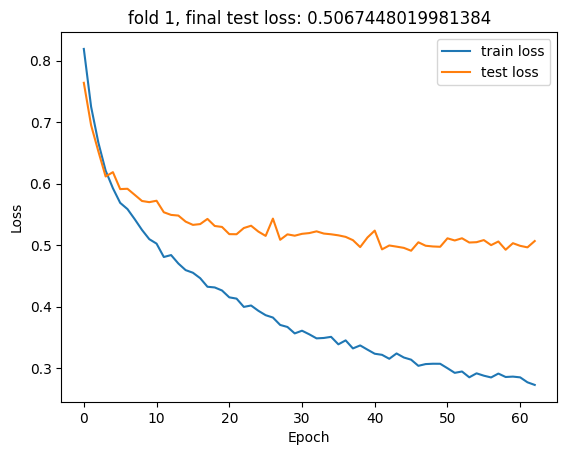

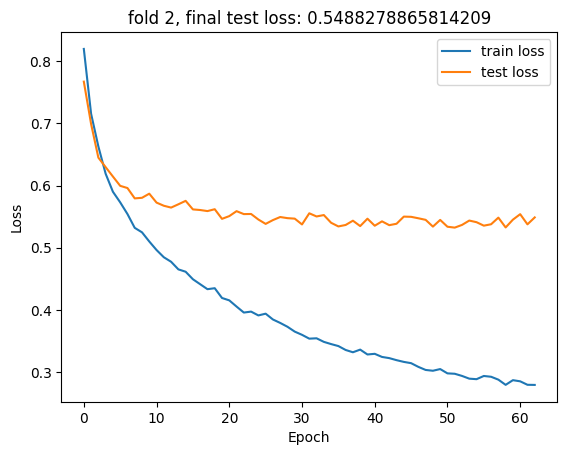

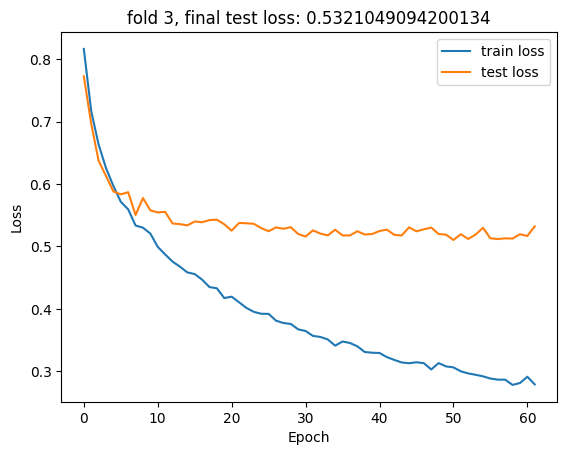

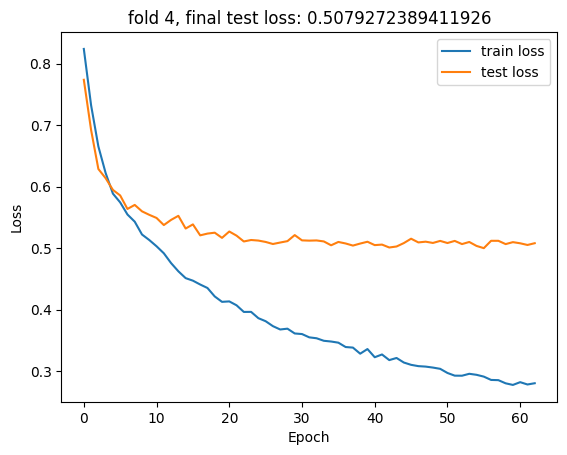

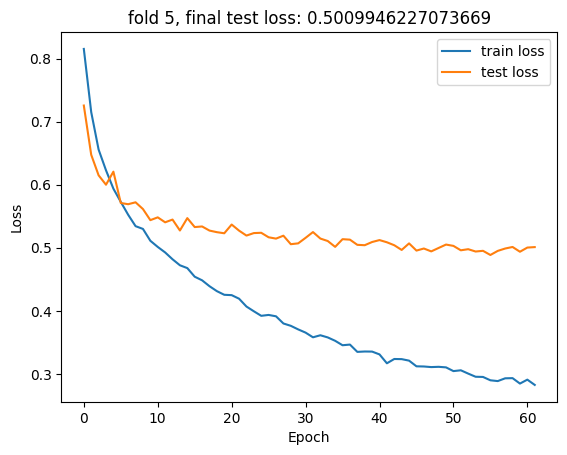

In [9]:
# plot train and test losses for each fold
plt.figure()
for i in range(n_folds):
    plt.plot(train_losses[i], label=f"train loss")
    plt.plot(test_losses[i], label=f"test loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"fold {i+1}, final test loss: {test_losses[i][-1]}")
    plt.show()

In [10]:
np.mean(scores)

0.5193198919296265

In [20]:
# load each model and print a confusion matrix
from sklearn.metrics import confusion_matrix

sig_dimension = signature_features.shape[2]
for fold in range(n_folds):
    model = EnsembleModel(sig_dimension, dropout, classifier_input_dim, hidden_layer_dim)
    model.load_state_dict(torch.load(f"model_logs/{folder_name}/model_{fold}.pt"))
    model.to(device)
    fold_size = len(dataset)//n_folds
    test_dataset = torch.utils.data.Subset(dataset, list(range(fold*fold_size, (fold+1)*fold_size)))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    model.eval()
    y_pred = []
    y_true = []
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred.append(model(x).detach().cpu().numpy())
        y_true.append(y.detach().cpu().numpy())
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_true, axis=1)
    print(f"fold {fold}")
    print(confusion_matrix(y_true, y_pred))
    print("")


fold 0
[[ 11  10  14   1   2  18]
 [  2 158  10   5   4  81]
 [  9   6  76   2   2  39]
 [  1  12   1  11   0  39]
 [  0   0   3   1  37  37]
 [  1  31  15   9  27 512]]

fold 1
[[  6   3  16   2   0  26]
 [  1 122   6   3   0  84]
 [  0   6  94   0   4  65]
 [  0   5   2  17   2  33]
 [  0   2   3   0  18  57]
 [  3  36  19  11  10 531]]

fold 2
[[  9   5  13   1   0  28]
 [  3 126   5   2   2 104]
 [  3   9  98   0   7  41]
 [  0  11   1  10   1  34]
 [  0   1   6   2  16  62]
 [  6  28  21   5   9 518]]

fold 3
[[ 12   6  10   1   0  17]
 [  0 144  17   4   1  80]
 [  2   9  84   1   7  25]
 [  0   4   2  12   3  37]
 [  0   4   5   0  14  64]
 [  4  38  37   9   9 525]]

fold 4
[[  9   7   7   0   2  15]
 [  4 113  10   1   1  75]
 [  6   6  94   0   9  42]
 [  2  10   1   4   5  46]
 [  0   4   3   1  18  69]
 [  9  19  34   5   8 548]]



In [13]:
TARGETS

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']